In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle

In [2]:
mail = pd.read_csv('mail.csv')
mail

,Category,Message
0,1,Free entry in 2 a wkly comp to win FA Cup fina...
1,1,FreeMsg Hey there darling it's been 3 week's n...
2,1,WINNER!! As a valued network customer you have...
3,1,Had your mobile 11 months or more? U R entitle...
4,1,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
8279,0,Update of /cvsroot/spamassassin/spamassassin/m...
8280,0,"\n\nFor anyone to fully bury global warming, t..."
8281,0,URL: http://diveintomark.org/archives/2002/10/...
8282,0,"\n\n\n\n>>>>> On Fri, 13 Sep 2002, ""Tony"" == T..."


In [3]:
mail.info(), mail.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8284 entries, 0 to 8283
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  8284 non-null   int64 
 1   Message   8284 non-null   object
dtypes: int64(1), object(1)
memory usage: 129.6+ KB


(None, (8284, 2))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


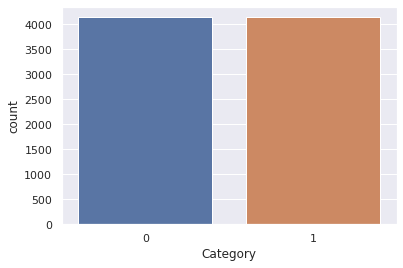

In [4]:
sns.set()
sns.countplot(mail.Category)
plt.show()

In [5]:
# Removing HTML tags
from bs4 import BeautifulSoup
mail['Message'] = [BeautifulSoup(text).get_text() for text in mail['Message']]

# Removing links/URLs
mail['Message'] = mail['Message'].replace(r'http\S+', '<linkhere>', regex=True).replace(r'www\S+', '<linkhere>', regex=True)

# Removing punctuation and non-alphabets
def remove_punctuation(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    return s

remove_non_alphabets = lambda x: re.sub(r'[^a-zA-Z ]',' ',x)

mail['Message'] = mail['Message'].apply(remove_punctuation)
mail['Message'] = mail['Message'].apply(remove_non_alphabets)

# Converting to lowercase
mail['Message'] = mail['Message'].str.lower()

# Removing stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
mail['Message'] = mail['Message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
mail

,Category,Message
0,1,free entry wkly comp win fa cup final tkts st ...
1,1,freemsg hey darling weeks word back id like fu...
2,1,winner valued network customer selected receiv...
3,1,mobile months u r entitled update latest colou...
4,1,six chances win cash pounds txt csh send cost ...
...,...,...
8279,0,update cvsrootspamassassinspamassassinmasses d...
8280,0,anyone fully bury global warming would bury gr...
8281,0,url linkhere date kevin fanning hallmark vs su...
8282,0,fri sep tony tony nugent wrote tony essence wa...


In [7]:
# Creating Tokenizer
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=20000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token="<OOV>")

In [8]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=None):
    sequences = tokenizer.texts_to_sequences(texts)
    
    if train == True:
        max_seq_length = np.max(list(map(lambda x: len(x), sequences)))
    
    sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=150, padding='post', truncating='post')
    
    return sequences

In [9]:
def mail_encoder(df):
    df = df.copy()

    # Split df into X and Y
    X = df['Message']
    Y = df['Category']

    # Train-Test-Validation Split - 70:15:15
    X_train, X_rem, Y_train, Y_rem = train_test_split(X, Y, train_size=0.7, shuffle=True, random_state=42)
    X_test, X_val, Y_test, Y_val = train_test_split(X_rem, Y_rem, test_size=0.5, shuffle=True, random_state=42)
    
    # Fitting the Tokenizer
    tokenizer.fit_on_texts(X_train)
    tokenizer.fit_on_texts(X_val)
    
    # Converting Texts to Sequences
    X_train = get_sequences(X_train, tokenizer, train=True)
    X_test = get_sequences(X_test, tokenizer, train=False, max_seq_length=X_train.shape[1])
    X_val = get_sequences(X_val, tokenizer, train=True)

    return X_train, X_test, X_val, Y_train, Y_test, Y_val

In [10]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = mail_encoder(mail)

In [11]:
len(tokenizer.word_index)

130577

In [12]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
X_train

array([[    8,  6210,   160, ...,  1798,    58, 10219],
       [  447,  3312,  2355, ...,     0,     0,     0],
       [  203,   465,   435, ...,     0,     0,     0],
       ...,
       [    8,   711,  4256, ...,  7764,   187,  5737],
       [    8,  3836,  1346, ...,     0,     0,     0],
       [  704,   250,     1, ...,     0,     0,     0]], dtype=int32)

In [14]:
X_test

array([[ 1566,   572,  5861, ...,    23,  1025,  1046],
       [    8,    20,  2431, ...,     0,     0,     0],
       [ 3908, 11245,   828, ...,     0,     0,     0],
       ...,
       [  844,  3063,    42, ...,     0,     0,     0],
       [  346,  3834,   100, ...,     4,     0,     0],
       [  707,    36,   557, ...,   658,    20,   345]], dtype=int32)

In [15]:
X_val

array([[   8,  363,  319, ...,    0,    0,    0],
       [   8,  932,  932, ...,    0,    0,    0],
       [3124, 1034, 1613, ...,    0,    0,    0],
       ...,
       [   8,  679, 9102, ...,    0,    0,    0],
       [ 707,   36,  557, ...,    5, 3414,    3],
       [   8, 1733, 2072, ...,    1,    1,    1]], dtype=int32)

In [16]:
X_train.shape, X_test.shape

((5798, 150), (1243, 150))

In [17]:
Y_train.value_counts()

0    2899
1    2899
Name: Category, dtype: int64

In [18]:
from keras.models import Sequential 
from keras.layers import Embedding, Bidirectional, Dense, Dropout
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU

In [19]:
model = Sequential()
model.add(Embedding(input_dim = 20000, 
                          output_dim = 64,
                          input_length = X_train.shape[1]
                          ))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(32, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNGRU(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(32, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer = opt,
    loss = 'binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 64)           1280000   
                                                                 
 dropout (Dropout)           (None, 150, 64)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 150, 64)          25088     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 150, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 150, 128)         49920     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 150, 128)          0

In [20]:
# EarlyStopping and ModelCheckpoint

from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=False)
mc = ModelCheckpoint('./model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [21]:
history = model.fit(
    X_train,
    Y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_val, Y_val),
    verbose=1,
    callbacks=[es, mc]
    )

Epoch 1/15
46/46 [==============================] - ETA: 0s - loss: 0.6915 - accuracy: 0.5321 - auc: 0.5831
Epoch 1: val_accuracy improved from -inf to 0.55511, saving model to ./model.h5
46/46 [==============================] - 22s 256ms/step - loss: 0.6915 - accuracy: 0.5321 - auc: 0.5831 - val_loss: 0.6883 - val_accuracy: 0.5551 - val_auc: 0.6901
Epoch 2/15
46/46 [==============================] - ETA: 0s - loss: 0.6783 - accuracy: 0.6638 - auc: 0.7187
Epoch 2: val_accuracy improved from 0.55511 to 0.72245, saving model to ./model.h5
46/46 [==============================] - 11s 231ms/step - loss: 0.6783 - accuracy: 0.6638 - auc: 0.7187 - val_loss: 0.6544 - val_accuracy: 0.7224 - val_auc: 0.7737
Epoch 3/15
46/46 [==============================] - ETA: 0s - loss: 0.5621 - accuracy: 0.7658 - auc: 0.8293
Epoch 3: val_accuracy improved from 0.72245 to 0.83347, saving model to ./model.h5
46/46 [==============================] - 11s 229ms/step - loss: 0.5621 - accuracy: 0.7658 - auc: 0.829

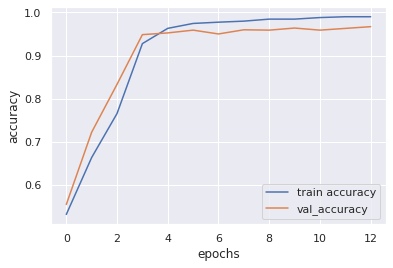

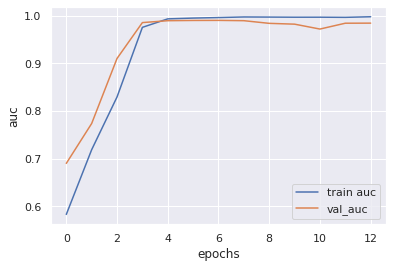

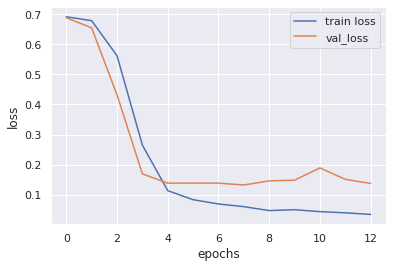

In [22]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("epochs")
  plt.ylabel(string)
  plt.legend(['train '+string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
print('\n')
plot_graphs(history, "auc")
print('\n')
plot_graphs(history, "loss")

In [23]:
model.evaluate(X_test, Y_test)

39/39 [==============================] - 4s 92ms/step - loss: 0.1161 - accuracy: 0.9662 - auc: 0.9889


[0.11614431440830231, 0.9662107825279236, 0.9889244437217712]

In [24]:
results = model.evaluate(X_test, Y_test, verbose=0)

print("    Test Loss: {:.4f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))
print("     Test AUC: {:.4f}".format(results[2]))

    Test Loss: 0.1161
Test Accuracy: 96.62%
     Test AUC: 0.9889


In [25]:
Y_pred = np.where(model.predict(X_test)>0.5, 1, 0)

In [26]:
from sklearn import metrics
print(metrics.classification_report(Y_pred, Y_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       624
           1       0.97      0.97      0.97       619

    accuracy                           0.97      1243
   macro avg       0.97      0.97      0.97      1243
weighted avg       0.97      0.97      0.97      1243



In [27]:
pd.DataFrame(
    metrics.confusion_matrix(Y_test, Y_pred),
    index = [['actual', 'actual'], ['ham', 'spam']],
    columns = [['predicted', 'predicted'], ['ham', 'spam']]
    )

predicted     
                  ham spam
actual ham        603   21
       spam        21  598

In [28]:
def predict(sentence):
    user_text = []
    user_text.append(sentence)
    seq = tokenizer.texts_to_sequences(user_text)
    pad = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=150, padding='post', truncating='post')
    probability = (model.predict(pad))[0][0]
    if probability > 0.5:
        print(f'Spam | {np.round(probability*100, 2)}%')
    else:
        print(f'Not Spam | {100 - (np.round(probability*100, 2))}%')

In [29]:
predict(str(input('Enter a mail: ')))

Enter a mail: Hey! Do you remember me? We met the other day.
Not Spam | 98.07%


In [30]:
benchmark = pd.read_csv('SpamAssassin.csv')
benchmark

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0
...,...,...
2995,abc s good morning america ranks it the NUMBE...,1
2996,hyperlink hyperlink hyperlink let mortgage le...,1
2997,thank you for shopping with us gifts for all ...,1
2998,the famous ebay marketing e course learn to s...,1


In [31]:
benchmark.rename(columns={'email': 'Message', 'label': 'Label'}, inplace=True)
benchmark

,Message,Label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0
...,...,...
2995,abc s good morning america ranks it the NUMBE...,1
2996,hyperlink hyperlink hyperlink let mortgage le...,1
2997,thank you for shopping with us gifts for all ...,1
2998,the famous ebay marketing e course learn to s...,1


In [32]:
benchmark_message = benchmark.Message.astype(str)

seq1 = tokenizer.texts_to_sequences(benchmark_message)
pad1 = tf.keras.preprocessing.sequence.pad_sequences(seq1, maxlen=150, padding='post', truncating='post')

prediction = model.predict(pad1)

benchmark['Prediction'] = pd.DataFrame(prediction)
benchmark.loc[(benchmark['Prediction'] > 0.5), 'Classification'] = 'spam'
benchmark.fillna('not spam', inplace=True)

In [33]:
benchmark

,Message,Label,Prediction,Classification
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0,0.005452,not spam
1,martin a posted tassos papadopoulos the greek ...,0,0.009881,not spam
2,man threatens explosion in moscow thursday aug...,0,0.011408,not spam
3,klez the virus that won t die already the most...,0,0.009555,not spam
4,in adding cream to spaghetti carbonara which ...,0,0.018249,not spam
...,...,...,...,...
2995,abc s good morning america ranks it the NUMBE...,1,0.995949,spam
2996,hyperlink hyperlink hyperlink let mortgage le...,1,0.996177,spam
2997,thank you for shopping with us gifts for all ...,1,0.996081,spam
2998,the famous ebay marketing e course learn to s...,1,0.996218,spam


In [34]:
benchmark.to_csv('Benchmark Results.csv')

In [35]:
benchmark['Label'].value_counts()

0    2500
1     500
Name: Label, dtype: int64

In [36]:
benchmark['Classification'].value_counts()

not spam    2414
spam         586
Name: Classification, dtype: int64